# MVP Tester

In this notebook we will import scripts which contain work done on other notebooks (including the trained RNN). Our goal here is to output our desired "MVP Result", which will be an image with a logo, and a generated tagline.

## 0) Import Scripts & Dependencies

In [ ]:
# Importing our scripts
import text_script as txtscript
import image_script as imscript

# Importing Libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont
import urllib.request
import subprocess
import os
import requests
import random
import json

Testing our **text_script**

In [ ]:
txtscript.evaluate('I', 20, temperature=0.6)

Now testing our ***image_script***

In [ ]:
imscript.generate_image('happy')

Looks great, its working fine!

## 1) Drawing Text w/ PIL

Our first step will be to generate an image file of the text we generate. This can be done with PIL. We will need to write a function for this

In [ ]:
# First attempt
def draw_text(text, size, fill=None):
    font = ImageFont.truetype(
        '~/Library/Fonts/Helvetica', size
    )
    size = font.getsize(text) # Returns the width and height of the given text, as a 2-tuple.
    im = Image.new('RGBA', size, (0, 0, 0, 0)) # Create a blank image with the given size
    draw = ImageDraw.Draw(im)
    draw.text((0, 0), text, font=font, fill=fill) #Draw text
    return im
 
img = draw_text('Apple', 30, (255, 124, 178))
plt.show(img)

Okay, we now have a (basic) way of writing text and storing it as an image

## 2) Create Image of Slogan

We now take it a step further, but providing draw text with our evaluation. To keep it clean, we will write a new function that call upon both ```draw_text``` and ```evaluate```

In [ ]:
def draw_slogan(num_candidates=5, predict_len=20, temperature=0.8, size=30, fill=None):
    final_slogans = []
    slogans = txtscript.get_candidates(num_candidates, predict_len, temperature)
    for slogan in slogans:
        final_slogans.append(draw_text(slogan, size, fill))
    return final_slogans

In [ ]:
draw_slogan('LIVE', fill=(82,124, 178))

Pretty simple implementation. Later we will want to replace ```evaluate``` for ```get_candidates```, so we have multiple options

## 3) Combining Slogan Image and Main Image

Now for what we have been waiting for (sort of). Lets put both images together! This is still going to look really shitty, but the most raw example of our MVP Result will be created :)

In [ ]:
def content_generator(description, num_candidates=5, predict_len=20, temperature=0.8, size=30, fill=None):
    main_image = imscript.generate_image(description)
    final_slogans = draw_slogan(num_candidates, predict_len, temperature, size, fill)
    # For now, randomly picking 1 final slogan
    slogan = random.choice(final_slogans)
    # Setting up center of main image for pasting
    image_w, image_h = main_image.size
    slogan_w, slogan_h = slogan.size
    center = ((image_w // 2) - (slogan_w // 2), (image_h // 2) - (slogan_h // 2))
    # Pasting
    main_image.paste(slogan, center, slogan)
    return main_image

Okay... lets try this thing out now...

In [ ]:
content_generator("Happy", num_candidates=1, fill=(82,124, 178))

## CAPITAL!

The Aplha-aplha version is now complete... lol

Regarding next steps:

- Improve RNN Performance 
- ```generate_image``` should provide a list of images with logos in different spots
- ```draw_text``` should be able to take different fonts (depending on availability), and color based on logo.
- ```generate_content``` should return a list of final results, with varying logo positions, taglines, and images

By achieving these 4 objectives, the product criteria for the MVP will be complete. **The next step will be developing a web application for its use.**

# Improvements / Next Steps

### Improve RNN Performance:

This is something I have already been working on. Need to improve my understanding of RNN's and building one from scratch in Pytorch. **For the basic MVP, this is the least important Improvement**

### Generating Images

I will need to restructure a little bit how the images are being generated with a given logo. In the *image_script.py*, I will have it just output a list of images without the logo. This will be more practical for putting the slogan in different places (while also having control of the logo)

### Draw Text

This is probably the easiest imporvement as all it needs is a given parameter in the function call.

### Generate Content

This will be built upon. improvements of ```generate_image```. We will need the *image_script.py* to return a list of various images, each that we can use appropriately.

## 4) Working on Improvements

In [ ]:
def generate_mockups(description='', num_samples=10, predict_len=20, temperature=0.8, size=30, fill=(82,124, 178), logo_path='./test_logo.png'):
    # Loading needed components
    main_images = imscript.generate_images(description, num_images=num_samples)
    slogans = txtscript.get_candidates(num_samples, predict_len, temperature)
    logo = Image.open(logo_path)
    
    # Looping through each main image JSON
    for image_data in main_images:
        # Getting Image and URL
        image, image_url = image_data
        # Getting sizes of images
        image_w, image_h = image.size
        logo_w, logo_h = logo.size
        
        # Creating Slogan Image
        slogan = slogans[main_images.index(image_data)]
        slogan = draw_text(slogan, (image_h // 16), fill)
        
        # Adjusting size of logo
        if logo_h >= logo_w:
            basewidth = image_w // 10
        else:
            basewidth = image_w // 4
            
        # Resized logo with new dimensions, and logomask    
        new_logo = imscript.resize_logo(logo, basewidth)
        logo_w , logo_h = new_logo.size
        logo_mask = new_logo.convert("RGBA")
        
        # Getting Box Coordinates
        top_right, top_left, bottom_right, bottom_left, center = imscript.get_boxes(image_w, image_h, logo_w, logo_w)
        boxes = [top_right, top_left, bottom_right, bottom_left, center]
        
        # Setting Box Coordinates for logo and slogan
        logo_box = random.choice(boxes)
        if logo_box == center:
            slogan_box = random.choice([top_right, top_left, bottom_right, bottom_left])
        elif logo_box == top_right or logo_box == top_left:
            slogan_box = random.choice([bottom_right, bottom_left, center])
        elif logo_box == bottom_right or logo_box == bottom_left:
            slogan_box = random.choice([top_right, top_left, center])
        
        # Now Pasting new_logo and slogan
        image.paste(new_logo, logo_box, logo_mask)
        image.paste(slogan, slogan_box, slogan)
    # Returning list of final mockups w/ URL
    return main_images
        
        

1- Load needed parts (images, slogans, logo)
2- Loop Through each image, which we will mutate with slogan and logo
    3- Generate slogan image
    4- Based on image width, adjust size of logo (new variable called new_logo)
    5- Set Box-Coordinates in Image for both logo and slogan (need to be different)
    6- Paste new_logo and slogan image on main image, based on box-coordinates
7- Return a list of the new mockups 

In [ ]:
big_test = generate_mockups('joy', num_samples=3)

In [ ]:
big_test[0][1]

In [1]:
import pollock

In [2]:
mockups = pollock.generate_mockups('social media', num_samples=1)

https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=social+media
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=social+media&category=
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=social+media&category=&image_type=all
https://pixabay.com/api/?key=9594603-1ab4b7442c4491ab852ebd1ee&q=social+media&category=&image_type=all&per_page=40
number of sentiment evaluations done: 1


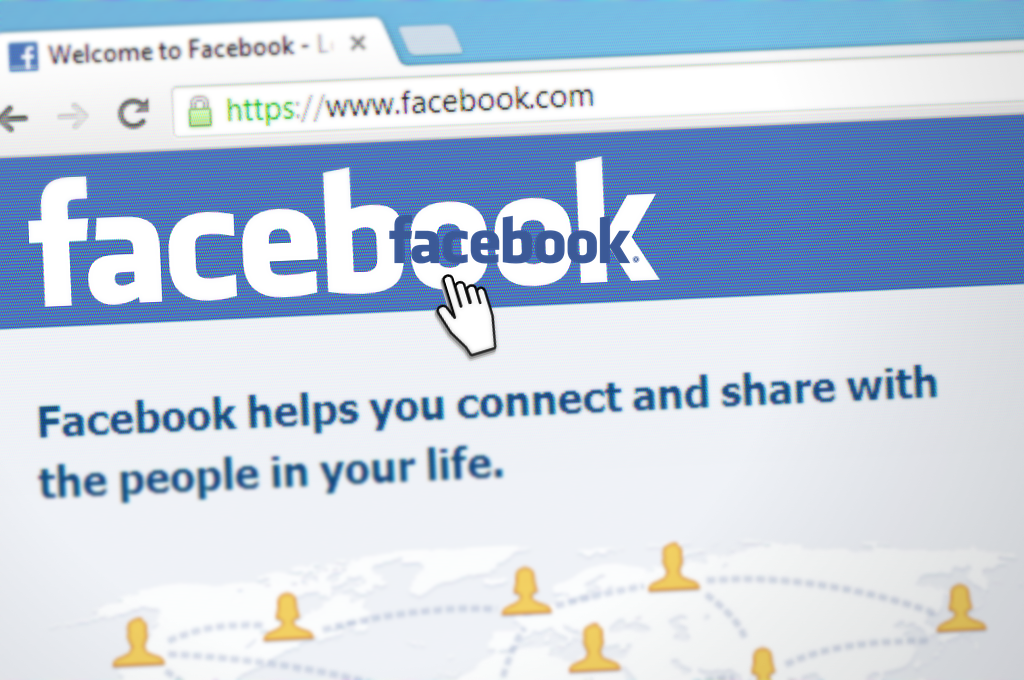

In [3]:
mockups[0]['image']

In [4]:
pollock.analyze(mockups[0])

 a close up of a person holding a remote 


{'caption': ' a close up of a person holding a remote ',
 'emotion': {'anger': 0.072296,
  'disgust': 0.052286,
  'fear': 0.075246,
  'joy': 0.077735,
  'sadness': 0.187394},
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x680 at 0x12034A128>,
 'slogan': 'ADp, but now we know ',
 'url': 'https://pixabay.com/get/ee33b40c2ae90021d85a5854ef494f92e577e1c818b412439cf5c879a7e4_1280.png'}